In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn nltk textblob streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.5 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()

Saving customer_feedback.csv to customer_feedback.csv


In [3]:
from google.colab import files
uploaded = files.upload()

Saving search_trends.csv to search_trends.csv


In [4]:
from google.colab import files
uploaded = files.upload()

Saving product_catalog.csv to product_catalog.csv


In [5]:
from google.colab import files
uploaded = files.upload()

Saving sales_data.csv to sales_data.csv


In [6]:
import pandas as pd

product_df = pd.read_csv('product_catalog.csv')
search_df = pd.read_csv('search_trends.csv')
feedback_df = pd.read_csv('customer_feedback.csv')
sales_df = pd.read_csv('sales_data.csv')

print(product_df.head())
print(search_df.head())
print(feedback_df.head())
print(sales_df.head())

  productId                         title  \
0     P1001          Solid Denim Tank Top   
1     P1002  Sleeveless Plaid Trench Coat   
2     P1003          Wool Printed Sandals   
3     P1004           Fitted Women Romper   
4     P1005         Loose Floral Sneakers   

                                         description     category  \
0  With influences of tank top combining solid pe...     tank top   
1  For fans of trench coat combining sleeveless m...  trench coat   
2  Meticulously crafted sandals combining wool st...      sandals   
3  Inspired by romper combining fitted performanc...       romper   
4  Made to celebrate sneakers combining loose ref...     sneakers   

           modifiers                     keywords releaseDate  
0       solid, denim       loose, white, tank top  2024-08-05  
1  sleeveless, plaid   white, winter, trench coat  2023-09-03  
2      wool, printed         wool, olive, sandals  2023-11-22  
3      fitted, women  sleeveless, striped, romper  2023-02

In [7]:
# Convert date columns to datetime
product_df['releaseDate'] = pd.to_datetime(product_df['releaseDate'], errors='coerce')
search_df['timestamp'] = pd.to_datetime(search_df['timestamp'], errors='coerce')
feedback_df['date'] = pd.to_datetime(feedback_df['date'], errors='coerce')
sales_df['timestamp'] = pd.to_datetime(sales_df['timestamp'], errors='coerce')

# Normalize search queries
search_df['query'] = search_df['query'].str.lower().str.strip()

# Drop rows with missing commentText in feedback
feedback_df = feedback_df.dropna(subset=['commentText'])

# Fill missing ratings with median value
feedback_df['rating'] = feedback_df['rating'].fillna(feedback_df['rating'].median())

# Strip spaces in reviewerName and location
feedback_df['reviewerName'] = feedback_df['reviewerName'].str.strip()
feedback_df['location'] = feedback_df['location'].str.strip()

In [8]:
print("✅ Cleaning Summary")
print("Product Catalog Rows:", len(product_df))
print("Search Trends Rows:", len(search_df))
print("Customer Feedback Rows:", len(feedback_df))
print("Sales Data Rows:", len(sales_df))
print("Missing Ratings After Cleaning:", feedback_df['rating'].isna().sum())
print("Unique Search Queries:", search_df['query'].nunique())

✅ Cleaning Summary
Product Catalog Rows: 10000
Search Trends Rows: 275837
Customer Feedback Rows: 273389
Sales Data Rows: 276243
Missing Ratings After Cleaning: 0
Unique Search Queries: 93738


In [9]:
import nltk
from textblob import TextBlob
nltk.download('punkt')

def get_sentiment(text):
    try:
        return TextBlob(str(text)).sentiment.polarity
    except:
        return 0

feedback_df['sentiment'] = feedback_df['commentText'].apply(get_sentiment)

# Average sentiment per product
sentiment_summary = feedback_df.groupby('productId')['sentiment'].mean().reset_index()
print(sentiment_summary.head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


  productId  sentiment
0    P10000   0.273705
1    P10001   0.313365
2    P10002   0.384592
3    P10003   0.366667
4    P10004   0.153333


In [10]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

# Download VADER Lexicon
nltk.download('vader_lexicon')

# Initialize sentiment analyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [11]:
!pip install nltk
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
import re

# Define a function to clean and substitute weak words
def clean_and_strengthen(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s.,!?]', '', text)  # remove emojis/symbols
    # Strengthen weak sentiment words
    substitutions = {
        "cheap": "poor quality",
        "meh": "bad",
        "ugh": "terrible",
        "late": "delayed",
        "not great": "bad",
        "not good": "poor",
        "not bad": "average",
        "ok": "average",
        "decent": "average",
        "perfect": "excellent",
        "nice": "good",
        "Just what i wanted": "good",
        "stylish": "good",
        "okay": "average",
        "reordered": "good",
        "happier": "good",
    }
    for weak, strong in substitutions.items():
        text = text.replace(weak, strong)
    return text

# Apply cleaning
feedback_df['cleaned_comment'] = feedback_df['commentText'].apply(clean_and_strengthen)

# Apply sentiment score to each review
feedback_df['sentiment_score'] = feedback_df['cleaned_comment'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

# Classify as Positive / Neutral / Negative
def label_sentiment(score):
    if score >= 0.40:
        return 'Positive'
    elif score <= 0.30:
        return 'Negative'
    else:
        return 'Neutral'

feedback_df['sentiment_label'] = feedback_df['sentiment_score'].apply(label_sentiment)

# Check sentiment distribution
print(feedback_df['sentiment_label'].value_counts())

# Optional: preview a few labeled reviews
feedback_df[['commentText', 'sentiment_score', 'sentiment_label']].head(50)


sentiment_label
Positive    146177
Negative    122137
Neutral       5075
Name: count, dtype: int64


,commentText,sentiment_score,sentiment_label
0,"Honestly, I found this tank top to be uncomfor...",0.2263,Negative
1,sizing and the material felt cheap..,-0.4767,Negative
2,delivery was late.. 🤷‍♂️🔥,0.0000,Negative
3,"From my experience, the tank top was perfect. ...",0.8126,Positive
4,The tank top is stylish. Goes well with everyt...,0.7263,Positive
5,one wash. Avoid this.. Z̷̦͓̰̲̈́̓̿͘Ȃ̷͉͔͚̝͌̈́̽͘͘͝...,-0.2960,Negative
6,"After wearing it, I think the tank top is high...",0.5719,Positive
7,The tank top is low-quality. Feels like a wast...,0.1280,Negative
8,"From my experience, the tank top was superb. T...",0.8750,Positive
9,The tank top is disappointing. Extremely disap...,-0.6997,Negative


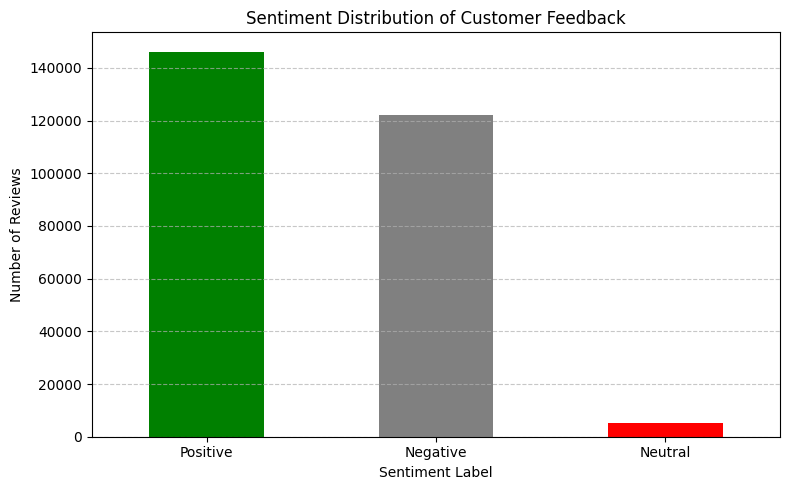

In [14]:
import matplotlib.pyplot as plt

# Count sentiment labels
sentiment_counts = feedback_df['sentiment_label'].value_counts()

# Plot
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['green', 'grey', 'red'])

# Labeling
plt.title("Sentiment Distribution of Customer Feedback")
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


In [19]:
search_df['timestamp'] = pd.to_datetime(search_df['timestamp'])
monthly_search = search_df.groupby([search_df['query'].str.lower(), search_df['timestamp'].dt.to_period('M')])['frequency'].sum().reset_index()
monthly_search.columns = ['query', 'month', 'frequency']

# Growth calculation
latest = monthly_search[monthly_search['month'] == monthly_search['month'].max()]
previous = monthly_search[monthly_search['month'] == monthly_search['month'].max() - 1]
merged = latest.merge(previous, on='query', suffixes=('_current', '_previous'))
merged['growthRate'] = ((merged['frequency_current'] - merged['frequency_previous']) / merged['frequency_previous']) * 100
top_trends = merged.sort_values(by='growthRate', ascending=False).head(10)

import json
trend_json = {
    "periodStart": str(monthly_search['month'].max() - 1),
    "periodEnd": str(monthly_search['month'].max()),
    "searchTerms": top_trends[['query', 'growthRate']].rename(columns={"query":"searchTerm"}).to_dict(orient='records')
}
with open('top_trending_keywords.json', 'w') as f:
    json.dump(trend_json, f, indent=2)

print(json.dumps(trend_json, indent=2))

{
  "periodStart": "2025-03",
  "periodEnd": "2025-04",
  "searchTerms": [
    {
      "searchTerm": "fuchsia",
      "growthRate": 1041.7721518987341
    },
    {
      "searchTerm": "minimalist loafer",
      "growthRate": 830.188679245283
    },
    {
      "searchTerm": "high-waisted shirt",
      "growthRate": 806.5573770491802
    },
    {
      "searchTerm": "low-rise blouse",
      "growthRate": 801.851851851852
    },
    {
      "searchTerm": "floral shirt",
      "growthRate": 762.6865671641791
    },
    {
      "searchTerm": "spring slim fit",
      "growthRate": 735.2941176470588
    },
    {
      "searchTerm": "floral coat",
      "growthRate": 697.9166666666667
    },
    {
      "searchTerm": "camel coat",
      "growthRate": 594.8275862068965
    },
    {
      "searchTerm": "slim fit sandals",
      "growthRate": 587.1428571428571
    },
    {
      "searchTerm": "striped skirt",
      "growthRate": 528.0701754385965
    }
  ]
}


📈 7-Day Demand Forecast for P1175
    0
0  28
1  21
2   8
3   8
4  29
5  29
6  28

📈 Forecast Comparison:
        Date  ARIMA  XGBoost  LSTM
0 2025-04-13     28       28    13
1 2025-04-14     14       21    16
2 2025-04-15      1        8    13
3 2025-04-16     10        8    18
4 2025-04-17     22       29    27
5 2025-04-18     21       29    20
6 2025-04-19      6       28    11


<Figure size 1000x600 with 0 Axes>

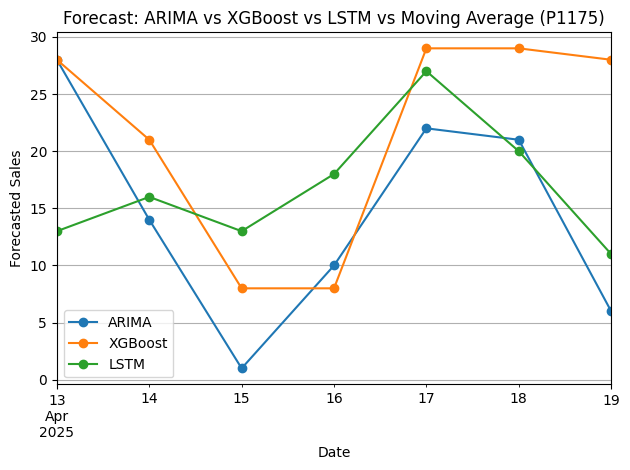

In [21]:
# 📚 Import Libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from textblob import TextBlob
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")



# ============================
# STEP 1: Load Your CSV Files
# ============================

sales_df = pd.read_csv('sales_data.csv')
feedback_df = pd.read_csv('customer_feedback.csv')
product_df = pd.read_csv('product_catalog.csv')

# Convert to datetime
sales_df['timestamp'] = pd.to_datetime(sales_df['timestamp'])
feedback_df['date'] = pd.to_datetime(feedback_df['date'])
product_df['releaseDate'] = pd.to_datetime(product_df['releaseDate'])

# ============================
# STEP 2: Prepare Feedback Data
# ============================

def get_sentiment(text):
    try:
        return TextBlob(str(text)).sentiment.polarity
    except:
        return 0

feedback_df['sentiment'] = feedback_df['commentText'].apply(get_sentiment)

feedback_summary = feedback_df.groupby('productId').agg({
    'rating': 'mean',
    'sentiment': 'mean',
    'commentText': 'count'
}).reset_index().rename(columns={
    'rating': 'avg_rating',
    'sentiment': 'avg_sentiment',
    'commentText': 'review_count'
})

# ============================
# STEP 3: Prepare Product Catalog
# ============================

def extract_season(modifiers):
    if pd.isnull(modifiers):
        return 'unknown'
    for season in ['summer', 'winter', 'spring', 'fall']:
        if season in modifiers.lower():
            return season
    return 'unknown'

product_df['season'] = product_df['modifiers'].apply(extract_season)
product_meta = product_df[['productId', 'category', 'season']]

# ============================
# STEP 4: Merge All Data
# ============================

# Merge product + feedback + sales
sales_merged = sales_df.merge(product_meta, on='productId', how='left')
sales_merged = sales_merged.merge(feedback_summary, on='productId', how='left')
sales_merged[['avg_rating', 'avg_sentiment', 'review_count']] = sales_merged[[
    'avg_rating', 'avg_sentiment', 'review_count']].fillna(0)

# 🧼 Load and Prepare Data
#sales_df = pd.read_csv('sales_data.csv')
#sales_df['timestamp'] = pd.to_datetime(sales_df['timestamp'])
#daily_sales = sales_df.groupby(['productId', 'timestamp'])['quantitySold'].sum().reset_index()

# ============================
# STEP 5: Feature Engineering
# ============================

sales_merged = sales_merged.sort_values(['productId', 'timestamp'])

# Select one product to forecast
product_id = 'P1175'  # Change to your target product
df = sales_merged[sales_merged['productId'] == product_id].copy()

df['day'] = (df['timestamp'] - df['timestamp'].min()).dt.days
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df['lag_1'] = df['quantitySold'].shift(1)
df['lag_7'] = df['quantitySold'].shift(7)
df = df.dropna()


# 🔍 Choose product with variation
#product_id = 'P1175'  # Replace if needed
#product_sales = daily_sales[daily_sales['productId'] == product_id]
#product_sales = product_sales.set_index('timestamp').resample('D').sum().fillna(0).reset_index()

# Check if enough variation exists
#if product_sales['quantitySold'].sum() < 10:
#    raise ValueError("⚠️ Not enough sales data or variation to forecast meaningfully.")

#product_sales['day'] = (product_sales['timestamp'] - product_sales['timestamp'].min()).dt.days

# ==============================
# 1. ARIMA Forecast
# ==============================
arima_model = ARIMA(df['quantitySold'], order=(5,1,0))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=7)

# ============================
# STEP 6: Train XGBoost Model
# ============================

features = ['day', 'dayofweek', 'is_weekend', 'lag_1', 'lag_7',
            'avg_rating', 'avg_sentiment', 'review_count']
X = df[features]
y = df['quantitySold']

X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, shuffle=False)
model = XGBRegressor(n_estimators=100)
model.fit(X_train, y_train)

# ============================
# STEP 7: Forecast Next 7 Days
# ============================

forecast_input = df.copy()
xgb_forecast = []

for i in range(7):
    last_row = forecast_input.iloc[-1]
    next_day = last_row['day'] + 1
    next_date = last_row['timestamp'] + pd.Timedelta(days=1)
    dow = next_date.dayofweek
    is_wknd = 1 if dow in [5, 6] else 0
    lag_1 = last_row['quantitySold']
    lag_7 = forecast_input.iloc[-7]['quantitySold'] if len(forecast_input) >= 7 else lag_1

    input_row = pd.DataFrame([{
        'day': next_day,
        'dayofweek': dow,
        'is_weekend': is_wknd,
        'lag_1': lag_1,
        'lag_7': lag_7,
        'avg_rating': last_row['avg_rating'],
        'avg_sentiment': last_row['avg_sentiment'],
        'review_count': last_row['review_count']
    }])

    pred = int(round(max(0, model.predict(input_row)[0])))
    xgb_forecast.append(pred)

    # Append new row for next forecast
    forecast_input = pd.concat([forecast_input, pd.DataFrame([{
        'timestamp': next_date,
        'day': next_day,
        'dayofweek': dow,
        'is_weekend': is_wknd,
        'lag_1': lag_1,
        'lag_7': lag_7,
        'quantitySold': pred,
        'avg_rating': last_row['avg_rating'],
        'avg_sentiment': last_row['avg_sentiment'],
        'review_count': last_row['review_count']
    }])], ignore_index=True)

forecast_df = pd.DataFrame(xgb_forecast)
print("📈 7-Day Demand Forecast for", product_id)
print(forecast_df)
# ==============================
# 3. LSTM Forecast
# ==============================
seq_data = df[['quantitySold']].values.astype(float)
scaler = MinMaxScaler()
scaled_seq = scaler.fit_transform(seq_data)

X_lstm = []
y_lstm = []
window = 7
for i in range(window, len(scaled_seq)):
    X_lstm.append(scaled_seq[i-window:i])
    y_lstm.append(scaled_seq[i])

X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

lstm_model = Sequential()
lstm_model.add(Input(shape=(X_lstm.shape[1], 1)))
lstm_model.add(LSTM(64, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_lstm, y_lstm, epochs=150, verbose=0)

lstm_forecast = []
last_seq = scaled_seq[-window:]

for _ in range(7):
    inp_seq = last_seq.reshape((1, window, 1))
    pred = lstm_model.predict(inp_seq, verbose=0)[0][0]
    lstm_forecast.append(pred)
    last_seq = np.append(last_seq[1:], pred)

lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast).reshape(-1, 1)).flatten().astype(int)


# ==============================
# Combined Forecast Output
# ==============================
forecast_dates = pd.date_range(start=df['timestamp'].max() + pd.Timedelta(days=1), periods=7)

combined = pd.DataFrame({
    'Date': forecast_dates,
    'ARIMA': arima_forecast.round().astype(int).values,
    'XGBoost': xgb_forecast,
    'LSTM': lstm_forecast
})


# 📈 Display & Plot
print("\n📈 Forecast Comparison:")
print(combined)

plt.figure(figsize=(10, 6))
combined.set_index('Date').plot(marker='o', title=f'Forecast: ARIMA vs XGBoost vs LSTM vs Moving Average ({product_id})')
plt.xlabel("Date")
plt.ylabel("Forecasted Sales")
plt.grid(True)
plt.tight_layout()
plt.show()



In [22]:
# ==============================
# 📤 Export JSON Forecast
# ==============================

forecast_json = {
    "productId": product_id,
    "forecastStart": str(forecast_dates[0].date()),
    "forecastDays": len(forecast_dates),
    "forecast": []
}

for i in range(len(forecast_dates)):
    forecast_json["forecast"].append({
        "date": str(forecast_dates[i].date()),
        "ARIMA": int(combined.loc[i, 'ARIMA']),
        "XGBoost": int(combined.loc[i, 'XGBoost']),
        "LSTM": int(combined.loc[i, 'LSTM'])
    })

# 💾 Save to JSON file
with open("product_demand_forecast.json", "w") as f:
    json.dump(forecast_json, f, indent=2)

# 🖨️ Preview JSON
print(json.dumps(forecast_json, indent=2))

{
  "productId": "P1175",
  "forecastStart": "2025-04-13",
  "forecastDays": 7,
  "forecast": [
    {
      "date": "2025-04-13",
      "ARIMA": 28,
      "XGBoost": 28,
      "LSTM": 13
    },
    {
      "date": "2025-04-14",
      "ARIMA": 14,
      "XGBoost": 21,
      "LSTM": 16
    },
    {
      "date": "2025-04-15",
      "ARIMA": 1,
      "XGBoost": 8,
      "LSTM": 13
    },
    {
      "date": "2025-04-16",
      "ARIMA": 10,
      "XGBoost": 8,
      "LSTM": 18
    },
    {
      "date": "2025-04-17",
      "ARIMA": 22,
      "XGBoost": 29,
      "LSTM": 27
    },
    {
      "date": "2025-04-18",
      "ARIMA": 21,
      "XGBoost": 29,
      "LSTM": 20
    },
    {
      "date": "2025-04-19",
      "ARIMA": 6,
      "XGBoost": 28,
      "LSTM": 11
    }
  ]
}


In [23]:
# Use last 7 actual values as test ground truth
actual = df.tail(7)['quantitySold'].values

# Trim forecasts to same length
arima_pred = arima_forecast[:len(actual)]
xgb_pred = xgb_forecast[:len(actual)]
lstm_pred = lstm_forecast[:len(actual)]

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # Fixed here
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100  # avoid div/0
    print(f"🔎 {name} Performance:")
    print(f"MAE : {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%\n")

In [25]:
evaluate_model("ARIMA", actual, arima_pred)
evaluate_model("XGBoost", actual, xgb_pred)
evaluate_model("LSTM", actual, lstm_pred)

🔎 ARIMA Performance:
MAE : 15.57
RMSE: 16.95
MAPE: 407.18%

🔎 XGBoost Performance:
MAE : 18.57
RMSE: 19.73
MAPE: 572.69%

🔎 LSTM Performance:
MAE : 13.00
RMSE: 14.33
MAPE: 407.32%



In [26]:
import re
from sklearn.feature_extraction.text import CountVectorizer

def clean_query(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

search_df['cleaned'] = search_df['query'].apply(clean_query)

vectorizer = CountVectorizer(stop_words='english')
tokens = vectorizer.fit_transform(search_df['cleaned'])


In [27]:

def get_sentiment(text):
    try:
        return TextBlob(str(text)).sentiment.polarity
    except:
        return 0

feedback_df['sentiment'] = feedback_df['commentText'].apply(get_sentiment)

# Join datasets
feedback_sentiment = feedback_df.groupby('productId')['sentiment'].mean().reset_index()
product_meta = product_df[['productId', 'category', 'modifiers']]
sales_with_meta = sales_df.merge(product_meta, on='productId', how='left')
sales_with_meta = sales_with_meta.merge(feedback_sentiment, on='productId', how='left')


In [28]:
import numpy as np

def extract_season(modifiers):
    if pd.isnull(modifiers):
        return 'unknown'
    modifiers = modifiers.lower()
    for season in ['summer', 'winter', 'fall', 'spring']:
        if season in modifiers:
            return season
    return 'unknown'

product_df['season'] = product_df['modifiers'].apply(extract_season)


In [29]:
# Ensure all timestamps are in datetime format
sales_df['timestamp'] = pd.to_datetime(sales_df['timestamp'])
feedback_df['sentiment'] = feedback_df['commentText'].apply(get_sentiment)  # if not already added

# Average sentiment per product
feedback_sentiment = feedback_df.groupby('productId')['sentiment'].mean().reset_index()

# Combine product metadata
product_df['season'] = product_df['modifiers'].fillna('').apply(extract_season)  # if extract_season is defined
product_meta = product_df[['productId', 'category', 'season']]

# Merge everything
sales_enriched = sales_df.merge(product_meta, on='productId', how='left')
sales_enriched = sales_enriched.merge(feedback_sentiment, on='productId', how='left')
sales_enriched = sales_enriched.dropna(subset=['category'])  # Drop incomplete data


In [30]:
# Aggregate demand per (category, season) per day
agg_df = sales_enriched.groupby(['timestamp', 'category', 'season'])['quantitySold'].sum().reset_index()

# Pivot to create time-series per category+season
pivot_df = agg_df.pivot_table(index='timestamp', columns=['category', 'season'], values='quantitySold', fill_value=0)


In [31]:
forecast_result = []

for (category, season) in pivot_df.columns:
    series = pivot_df[(category, season)].rolling(window=7).mean().dropna()
    last_value = int(series[-1])  # latest smoothed value
    forecast_result.append({
        "category": category,
        "season": season,
        "forecastedQuantity": last_value
    })

category_forecast_json = {
    "periodStart": str(pivot_df.index.max() + pd.Timedelta(days=1)),
    "periodEnd": str(pivot_df.index.max() + pd.Timedelta(days=7)),
    "forecast": forecast_result
}

import json
with open("category_and_attribute_demand_forecast.json", "w") as f:
    json.dump(category_forecast_json, f, indent=2)

print(json.dumps(category_forecast_json, indent=2))

{
  "periodStart": "2025-05-01 00:00:00",
  "periodEnd": "2025-05-07 00:00:00",
  "forecast": [
    {
      "category": "blouse",
      "season": "fall",
      "forecastedQuantity": 6
    },
    {
      "category": "blouse",
      "season": "spring",
      "forecastedQuantity": 5
    },
    {
      "category": "blouse",
      "season": "summer",
      "forecastedQuantity": 6
    },
    {
      "category": "blouse",
      "season": "unknown",
      "forecastedQuantity": 90
    },
    {
      "category": "blouse",
      "season": "winter",
      "forecastedQuantity": 2
    },
    {
      "category": "bomber jacket",
      "season": "fall",
      "forecastedQuantity": 3
    },
    {
      "category": "bomber jacket",
      "season": "spring",
      "forecastedQuantity": 0
    },
    {
      "category": "bomber jacket",
      "season": "summer",
      "forecastedQuantity": 7
    },
    {
      "category": "bomber jacket",
      "season": "unknown",
      "forecastedQuantity": 105
    },
  

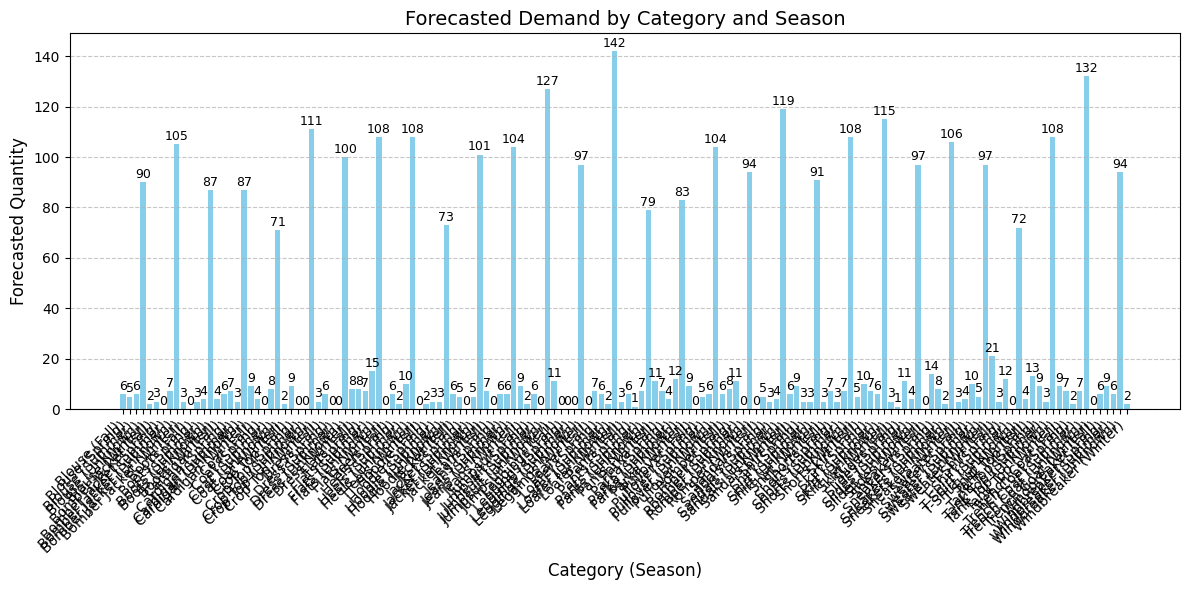

In [33]:
import matplotlib.pyplot as plt

# Create labels and values
labels = [f"{item['category'].title()} ({item['season'].title()})" for item in forecast_result]
values = [item['forecastedQuantity'] for item in forecast_result]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values, color='skyblue')
plt.title("Forecasted Demand by Category and Season", fontsize=14)
plt.xlabel("Category (Season)", fontsize=12)
plt.ylabel("Forecasted Quantity", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f"{height}", xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

plt.show()

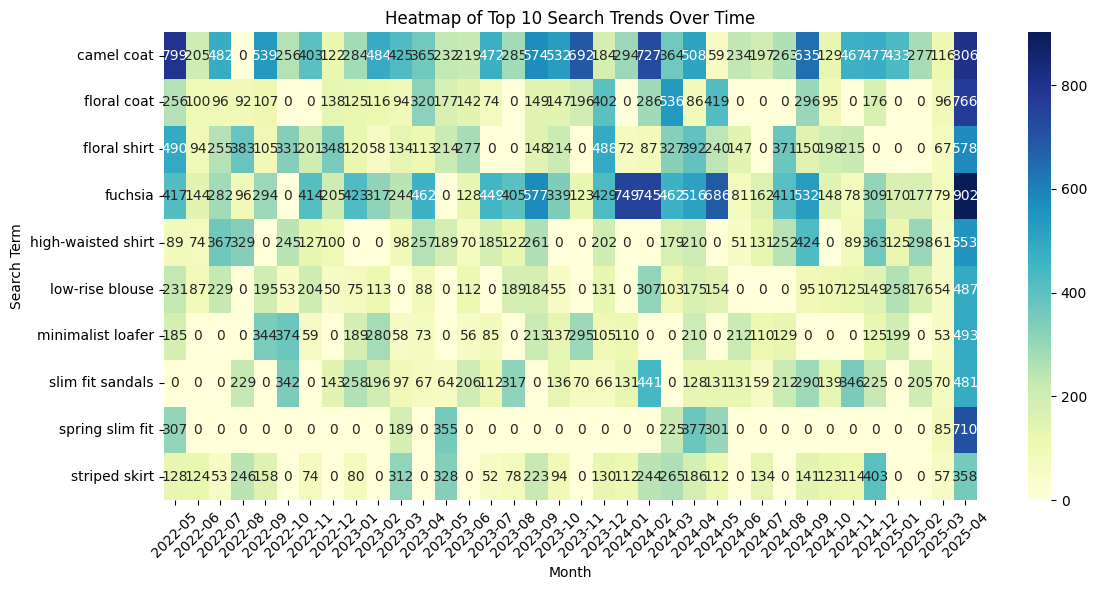

In [34]:
top_queries = top_trends['query'].head(10).tolist()
trend_data = monthly_search[monthly_search['query'].isin(top_queries)]
trend_data['month'] = trend_data['month'].astype(str)

pivot_trend = trend_data.pivot_table(index='query', columns='month', values='frequency', fill_value=0)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.heatmap(pivot_trend, annot=True, fmt='.0f', cmap="YlGnBu")
plt.title("Heatmap of Top 10 Search Trends Over Time")
plt.ylabel("Search Term")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [35]:
import json

# Assuming `top_queries` already holds the top 10 search terms
top_queries_json = {"top_search_queries": top_queries}

# Save to file (optional)
with open("top_search_queries.json", "w") as f:
    json.dump(top_queries_json, f, indent=2)

# Print nicely formatted JSON
print(json.dumps(top_queries_json, indent=2))

{
  "top_search_queries": [
    "fuchsia",
    "minimalist loafer",
    "high-waisted shirt",
    "low-rise blouse",
    "floral shirt",
    "spring slim fit",
    "floral coat",
    "camel coat",
    "slim fit sandals",
    "striped skirt"
  ]
}


In [36]:
!pip install streamlit pyngrok plotly pandas numpy seaborn xgboost textblob

In [37]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px
import json

st.set_page_config(page_title="TrendIQ Dashboard", layout="wide")

st.title("📊 TrendIQ – AI-Powered Trend & Demand Analyzer")

# File Upload
st.sidebar.header("📁 Upload Required Files")
search_trends = st.sidebar.file_uploader("Upload search_trends.csv", type=["csv"])
product_catalog = st.sidebar.file_uploader("Upload product_catalog.csv", type=["csv"])
customer_feedback = st.sidebar.file_uploader("Upload customer_feedback.csv", type=["csv"])
sales_data = st.sidebar.file_uploader("Upload sales_data.csv", type=["csv"])
product_forecast_json = st.sidebar.file_uploader("Upload product_demand_forecast.json", type=["json"])
category_forecast_json = st.sidebar.file_uploader("Upload category_and_attribute_demand_forecast.json", type=["json"])
trend_combo_json = st.sidebar.file_uploader("Upload trending_category_season_quantity.json", type=["json"])
top_keywords_json = st.sidebar.file_uploader("Upload top_trending_keywords.json", type=["json"])

if all([search_trends, product_catalog, customer_feedback, sales_data,
        product_forecast_json, category_forecast_json, trend_combo_json, top_keywords_json]):

    # Load CSVs
    search_df = pd.read_csv(search_trends)
    product_df = pd.read_csv(product_catalog)
    feedback_df = pd.read_csv(customer_feedback)
    sales_df = pd.read_csv(sales_data)

    # Load JSONs
    product_forecast = json.load(product_forecast_json)
    category_forecast = json.load(category_forecast_json)
    trend_combo = json.load(trend_combo_json)
    top_keywords = json.load(top_keywords_json)

    st.header("1️⃣ Top 10 Trending Search Terms")
    trends_df = pd.DataFrame(top_keywords['searchTerms'])
    fig1 = px.bar(trends_df, x="searchTerm", y="growthRate", title="Search Term Growth Rate", color="growthRate")
    st.plotly_chart(fig1, use_container_width=True)

    st.header("2️⃣ Category + Season Forecast")
    combo_df = pd.DataFrame(trend_combo['topForecastedCategorySeasonCombos'])
    st.dataframe(combo_df)
    fig2 = px.bar(combo_df, x='category', y='forecastedQuantities', color='season', title="Category + Season Forecast")
    st.plotly_chart(fig2, use_container_width=True)

    st.header("3️⃣ Product Demand Forecast (ARIMA, XGBoost, LSTM)")
    forecast_df = pd.DataFrame(product_forecast['forecast'])
    forecast_df['date'] = pd.to_datetime(forecast_df['date'])
    fig3 = px.line(forecast_df, x='date', y=['ARIMA', 'XGBoost', 'LSTM'], title=f"Product Forecast ({product_forecast['productId']})")
    st.plotly_chart(fig3, use_container_width=True)

    st.header("4️⃣ Weekly Category Forecast")
    cat_df = pd.DataFrame(category_forecast['forecast'])
    fig4 = px.bar(cat_df, x="category", y="forecastedQuantity", color="season", title="Weekly Category-Level Forecast")
    st.plotly_chart(fig4, use_container_width=True)

    st.success("✅ Dashboard Loaded. Use the sidebar to re-upload files.")
else:
    st.warning("🚨 Please upload all required files from the sidebar to begin.")

Writing app.py


In [38]:
from pyngrok import ngrok

# Kill any running tunnels
ngrok.kill()

# Run the Streamlit app
!streamlit run app.py &

# Open a tunnel to streamlit port 8501
public_url = ngrok.connect(port=8501)
print("🔗 Open this Streamlit Dashboard URL:")
print(public_url)




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.132.207.2:8501

  Stopping...


ERROR:pyngrok.process.ngrok:t=2025-05-31T11:01:08+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-05-31T11:01:08+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"


PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

In [40]:
from google.colab import files

# List of JSON files to download
json_files = [
    "product_demand_forecast.json",
    "category_and_attribute_demand_forecast.json",
    "trending_category_season_quantity.json",
    "top_trending_keywords.json"
]

# Download each file
for file in json_files:
    try:
        files.download(file)
        print(f"✅ Downloaded: {file}")
    except Exception as e:
        print(f"❌ Could not download {file}: {e}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: product_demand_forecast.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: category_and_attribute_demand_forecast.json
❌ Could not download trending_category_season_quantity.json: Cannot find file: trending_category_season_quantity.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: top_trending_keywords.json
